In [ ]:
#encorporate cnn output size
#try to add timestamp back in?
#try to toggle the preembed?

In [1]:
from dataset_class import SleepDataset, SleepChunkDataset
import codecs
import math
import random
import string
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score
import torch.nn as nn
from torch.autograd import Variable
from torchmetrics.classification import MulticlassCohenKappa
import torch
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from dataset_class import SleepDataset, SleepChunkDataset
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers.wandb import WandbLogger
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import wandb

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
small = False
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

### Train Test Split

In [3]:
device

device(type='cuda', index=0)

In [4]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

# overwrite with smaller dataset for development (30% of original)
fraction = 0.3
subjects_train_small = subjects_train[:int(len(subjects_train)*fraction)]
subjects_val_small = subjects_val[:int(len(subjects_val)*fraction)]
subjects_test_small = subjects_test[:int(len(subjects_test)*fraction)]
print(f"number of subjects in small train: {len(subjects_train_small)}")
print(f"number of subjects in small val: {len(subjects_val_small)}")
print(f"number of subjects in small test: {len(subjects_test_small)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10
number of subjects in small train: 24
number of subjects in small val: 3
number of subjects in small test: 3


In [ ]:
# train_dataset = SleepChunkDataset(subjects_list=["S003"],
#                                  data_dir=data_dir,
#                                  debug=False)

In [ ]:
chunk_duration = 600
chunk_stride = 300

if small == False:
    train_dataset_mixed = SleepChunkDataset(subjects_list=subjects_train,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
    val_dataset_mixed = SleepChunkDataset(subjects_list=subjects_val,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
    test_dataset_mixed = SleepChunkDataset(subjects_list=subjects_test,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in test dataset: {len(test_dataset_mixed)}")
else:
    train_dataset_mixed = SleepChunkDataset(subjects_list=subjects_train_small,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in train dataset small: {len(train_dataset_mixed)}")
    val_dataset_mixed = SleepChunkDataset(subjects_list=subjects_val_small,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in val dataset small: {len(val_dataset_mixed)}")
    test_dataset_mixed = SleepChunkDataset(subjects_list=subjects_test_small,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in test dataset small: {len(test_dataset_mixed)}")

In [ ]:
# get class weights for weighted loss
all_labels = []
for batch_idx, (data, targets) in enumerate(DataLoader(train_dataset_mixed, batch_size=1)):
    targets = targets.numpy()
    all_labels.extend(targets.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(5)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

In [ ]:
def get_datasets(chunk_duration,chunk_stride):
    train_dataset_mixed = SleepChunkDataset(subjects_list=subjects_train,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
    val_dataset_mixed = SleepChunkDataset(subjects_list=subjects_val,
                                     data_dir=data_dir,
                                     chunk_duration=chunk_duration,
                                     chunk_stride=chunk_stride,
                                     debug=False)
    return train_dataset_mixed,val_dataset_mixed

### ActiNet + Plot Loss

In [8]:
def plot_loss(train_losses, val_losses, num_epochs):
    # Plotting the loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)  # Optional: Adds gridlines for better readability
    plt.show()
    return plt

In [9]:

class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=cnn_output_channels, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=cnn_output_channels, out_channels=cnn_output_channels, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=cnn_output_channels, out_channels=cnn_output_channels, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=cnn_output_channels, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(0.25)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        
        # self.fc1 = nn.Linear(16, 64)  # Adjust input size based on final pooled size
        # self.fc2 = nn.Linear(64, 10)  # Replace 10 with the number of output classes
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #print(initial_samples)
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)
        #print(final_samples)

        
        #print(f'start shape {x.shape}')
        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x


### LSTM

In [10]:
class SleepStager(pl.LightningModule):
    def __init__(self,
                cnn_output_channels: int = 16,
                pre_lstm_embedding_size: int = 16,
                lstm_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 5,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                debug:            bool = False):
        super().__init__()
        # self.save_hyperparameters()
        
        self.acc_cnn = DeepACTINeT(cnn_output_channels)
        #add non linearity to the bvp and temp before lstm 
        self.embeddingLayer = nn.Linear(2, pre_lstm_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        self.pre_lstm_embedding_size = pre_lstm_embedding_size

        self.lstm_hidden_size = lstm_hidden_size
        self.hidden_size2 = hidden_size2
        self.lstm_input_size = self.pre_lstm_embedding_size + self.cnn_output_channels
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=self.lstm_hidden_size,
                            bias = True,
                            batch_first=False,
                            bidirectional = True)
        #From paper 
        self.hidden2 = nn.Linear(lstm_hidden_size*2, hidden_size2)
        self.classifier = nn.Linear(hidden_size2, num_sleep_stages)
    
        self.criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)


        self.dropout = nn.Dropout(p=0.5)
        
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        #self.outputLayer = nn.Linear(self.hidden_size*self.seq_len, self.output_size)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        acc_feats = self.acc_cnn(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)

        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout(emb_non_acc)
        # 3) build LSTM input: (T', batch, feature_dim)
        a = acc_feats.permute(2, 0, 1)        # (lstm_seq_len, batch, cnn_output_features)
        b = emb_non_acc.permute(1, 0, 2)       # (lstm_seq_len, batch, non_acc_dim)
        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}") # (batch, non_acc_length, non_acc_dim)
       
        lstm_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)

#             [DEBUG] ACC CNN output shape: torch.Size([8, 16, 120])
# [DEBUG] NON_ACC input shape: torch.Size([8, 120, 2])
# [DEBUG] LSTM input shape: torch.Size([120, 8, 18])

        if self.debug:
            print(f"[DEBUG] LSTM input shape: {lstm_in.shape}")
            print(f"[DEBUG] LSTM hidden size: {self.lstm_hidden_size}")
    
        # 4) LSTM + classifier
        hidden = self.init_hidden(lstm_in.shape[1],self.lstm_hidden_size).to(device)
        cell = self.init_hidden(lstm_in.shape[1],self.lstm_hidden_size).to(device)
        if self.debug:
            print(f"[DEBUG] LSTM hidden shape: {hidden.shape}")
        output,(hidden, cell) = self.lstm(lstm_in, (hidden, cell))
        if self.debug:
            print(f"[DEBUG] LSTM output shape: {output.shape}")

        
        pre_output = self.hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {pre_output.shape}")
        y_hat = self.classifier(pre_output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
        
    def init_hidden(self, batch_size, hidden):
        #print(f"[DEBUG] LSTM hidden size within init_hidden: {self.lstm_hidden_size}")
        return torch.randn(2,batch_size,hidden).to(device)
    
    def training_step(self, batch, batch_idx):
        data, labels = batch
        acc, non_acc = data['acc_data'], data['tempbvp_data']
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        data, labels = batch
        acc, non_acc = data['acc_data'], data['tempbvp_data']
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        
    
        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        self.log("val_cohen_kappa", ckappa, prog_bar=True)
    
        self.kappa.reset()
    
        return {"val_loss": loss, "val_acc": acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_cohen_kappa',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Small old run

In [ ]:
train_dataset = SleepChunkDataset(subjects_list=["S003"],
                                 data_dir=data_dir,
                                 debug=False)
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, shuffle=True)
#just a quick lil pass to see if all the shapes are lining up 
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [24]:
#THIS IS WHAT UR TRYING TO RUN
train_loader = DataLoader(train_dataset_mixed, batch_size=8, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset_mixed, batch_size=8, num_workers=8, shuffle=True)
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)
model = SleepStager(
                pre_lstm_embedding_size= 16,
                lstm_hidden_size= 128,
                hidden_size2 = 64,
                num_sleep_stages = 5,
                lr = 1e-3,
                weight_tensor=weight_tensor.to(device),
                debug= False)
model = model.to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=weight_tensor.to(device), ignore_index = -1)
kappa = MulticlassCohenKappa(num_classes=5).to(device)

Running epoch: 0
Running epoch: 1
Running epoch: 2
Running epoch: 3
Running epoch: 4
Running epoch: 5
Running epoch: 6
Running epoch: 7
Running epoch: 8
Running epoch: 9
Running epoch: 10


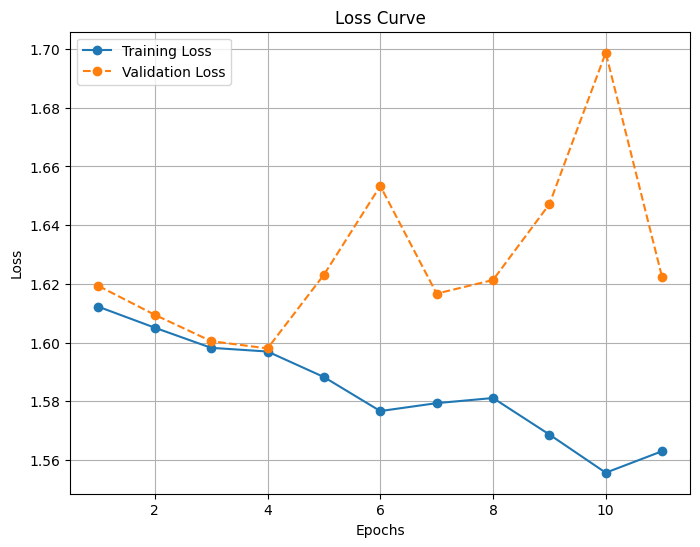

Running epoch: 11
Running epoch: 12
Running epoch: 13
Early stopping triggered at epoch 14
Cohens Kappa -0.016968369483947754


In [25]:
num_epochs = 50
train_losses = []
epoch_times = []
patience = 10
val_losses = []
best_val_loss = float('inf')  # To track the best validation loss
patience_counter = 0         # Counter for early stopping
    # Trainable embeddings
for epoch in range(num_epochs):
    print("Running epoch:", epoch)
    model.train()  # Set the model to training mode
    epoch_loss = 0

    start_time = time.time()  # Track epoch start time
    for batch_idx, (data, targets) in enumerate(train_loader):  # Assuming `train_loader` is your DataLoader for training
        acc = data['acc_data'].to(device)
        non_acc = data['tempbvp_data'].to(device)
        labels = targets.to(device)
        # print(f'inputs shape: {inputs.shape}')
        # print(f'labels shape: {labels.shape}')
        optimizer.zero_grad()  # Reset gradients
       
        outputs = model(acc, non_acc)  # Forward pass

        y_hat = outputs.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        predictions = torch.argmax(y_hat_flat, dim=1)
        
        # calculate loss
        loss = criterion(y_hat_flat, labels_flat)
        
        loss.backward()  # Backpropagate
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()  # Update weights
        
        epoch_loss += loss.item()
            # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            val_acc = data['acc_data'].to(device)
            val_non_acc = data['tempbvp_data'].to(device)
            val_labels = targets.to(device)
            
            val_outputs = model(val_acc, val_non_acc)  # Forward pass
            y_hat = val_outputs.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
            batch_size, output_length, num_sleep_stages = y_hat.shape
            y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
            labels_flat  = val_labels.reshape(batch_size * output_length)
            loss = criterion(y_hat_flat, labels_flat)
        
            val_loss += loss.item()

                # calculate accuracy
            predictions = torch.argmax(y_hat_flat, dim=1)
            mask = labels_flat != -1
            masked_preds = predictions[mask]
            masked_labels = labels_flat[mask]
            if masked_labels.numel() > 0:
                acc = (masked_preds == masked_labels).float().mean().item()
            else:
                acc = 0.0
        
            # calculate cohen's kappa
            mask = labels_flat != -1
            y_valid = labels_flat[mask]
            preds_valid = predictions[mask]
            if y_valid.numel() > 0:
                ckappa = kappa(preds_valid, y_valid)
            else:
                ckappa = torch.tensor(0.0, device=self.device)


    # Record average validation loss
    val_losses.append(val_loss / len(val_loader))

    # Early stopping check
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
    
    epoch_time = time.time() - start_time  # Calculate epoch training time
    train_losses.append(epoch_loss / len(train_loader))
    epoch_times.append(epoch_time)
    
    if epoch % 10 == 0 and epoch != 0:
        plt = plot_loss(train_losses, val_losses, num_epochs)
        plt.show()
print(f'Cohens Kappa {ckappa}')

In [26]:
labels_flat

tensor([0, 0, 0,  ..., 2, 2, 2], device='cuda:0')

In [29]:
torch.unique(predictions)

tensor([0, 1, 2, 3, 4], device='cuda:0')

In [45]:
y_hat.shape

torch.Size([5, 2400, 5])

In [ ]:
(batch, lstm_seq_len, num_sleep_stages)

In [46]:
labels.shape

torch.Size([3, 2400])

In [22]:
for batch_idx, (data, targets) in enumerate(train_loader):
    optimizer.zero_grad()
    print(targets[0].shape)
    outputs = model(data['acc_data'], data['tempbvp_data'])
        # outputs: [120, 8, 5] → [8, 120, 5]
    outputs = outputs.permute(1, 0, 2)
    
    # Flatten: [8, 120, 5] → [960, 5]
    outputs = outputs.reshape(-1, outputs.shape[-1])
    
    # targets: [8, 120] → [960]
    targets = targets.reshape(-1)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    break



torch.Size([120])
120
start shape torch.Size([8, 3, 19200])
Input shape after conv1: torch.Size([8, 16, 9345])
Input shape after, dropout: torch.Size([8, 16, 9345])
Input shape after conv1,dropout,batchnorm: torch.Size([8, 16, 9345])
Input shape after maxpool: torch.Size([8, 16, 4672])
Input shape after conv2: torch.Size([8, 16, 2209])
Input shape after conv3: torch.Size([8, 16, 977])
Input shape after maxpool: torch.Size([8, 16, 488])
before avg pooling shape: torch.Size([8, 16, 229])
Final output shape: torch.Size([8, 16, 120])
[DEBUG] ACC CNN output shape: torch.Size([8, 16, 120])
[DEBUG] NON_ACC input shape: torch.Size([8, 120, 2])
[DEBUG] ACC CNN reshaped shape: torch.Size([120, 8, 16])
[DEBUG] NON_ACC reshaped shape: torch.Size([120, 8, 16])
[DEBUG] LSTM input shape: torch.Size([120, 8, 32])
[DEBUG] LSTM output shape: torch.Size([120, 8, 128])
[DEBUG] hidden2 shape: torch.Size([120, 8, 64])
[DEBUG] Classifier output shape: torch.Size([120, 8, 5])


In [24]:
outputs.shape

torch.Size([120, 5])

In [31]:
wandb_logger = WandbLogger(project="acc_aware_model")


In [7]:
pwd

'/home/npr264/DeepLearning/project'

In [10]:
device

device(type='cpu')

In [ ]:
e3f0c7f1826bf92a6527c3877acb8f1a8f8493c1

In [34]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/scratch/npr264/BioDeepL/project/checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback]
)
model = SleepStager( # cnn_output 32, lstm_hidden 128, lr 1e-4 did ok
    # non_acc_dim=5,
    # cnn_output_channels=best_cnn_output_channels,
    # lstm_hidden_size=best_lstm_hidden_size,
    # lstm_layers=2,
    # num_sleep_stages=5,
    # lr=best_learning_rate,
    weight_tensor=torch.tensor(class_weights, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset_mixed, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset_mixed, batch_size=8, shuffle=False)
trainer.fit(model, train_loader, val_loader)
wandb.finish()
# Load the best model
best_model_path = checkpoint_callback.best_model_path

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params | Mode 
----------------------------------------------------------------
0 | acc_cnn        | DeepACTINeT          | 164 K  | train
1 | embeddingLayer | Linear               | 48     | train
2 | lstm           | LSTM                 | 165 K  | train
3 | hidden2        | Linear               | 16.4 K | train
4 | classifier     | Linear               | 325    | train
5 | criterion      | CrossEntropyLoss     | 0      | train
6 | kappa          | MulticlassCohenKappa | 0      | train
7 | dropout        | Dropout              | 0      | train
-------------------------------------------------------

Epoch 0: 100%|██████████| 25/25 [00:05<00:00,  4.92it/s, v_num=8n4g, train_loss_step=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, v_num=8n4g, train_loss_step=1.600, val_loss=1.630, val_acc=0.212, val_cohen_kappa=0.0472, train_loss_epoch=1.610]

Metric val_loss improved. New best score: 1.629


Epoch 1: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s, v_num=8n4g, train_loss_step=1.560, val_loss=1.630, val_acc=0.212, val_cohen_kappa=0.0472, train_loss_epoch=1.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, v_num=8n4g, train_loss_step=1.560, val_loss=1.620, val_acc=0.195, val_cohen_kappa=0.0465, train_loss_epoch=1.600]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.622


Epoch 2: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s, v_num=8n4g, train_loss_step=1.620, val_loss=1.620, val_acc=0.195, val_cohen_kappa=0.0465, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s, v_num=8n4g, train_loss_step=1.620, val_loss=1.630, val_acc=0.145, val_cohen_kappa=0.0254, train_loss_epoch=1.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 25/25 [00:05<00:00,  4.62it/s, v_num=8n4g, train_loss_step=1.620, val_loss=1.610, val_acc=0.138, val_cohen_kappa=0.00922, train_loss_epoch=1.590]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.608


Epoch 4: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s, v_num=8n4g, train_loss_step=1.550, val_loss=1.610, val_acc=0.138, val_cohen_kappa=0.00922, train_loss_epoch=1.590]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 25/25 [00:05<00:00,  4.92it/s, v_num=8n4g, train_loss_step=1.640, val_loss=1.640, val_acc=0.131, val_cohen_kappa=0.00895, train_loss_epoch=1.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 25/25 [00:05<00:00,  4.93it/s, v_num=8n4g, train_loss_step=1.580, val_loss=1.640, val_acc=0.135, val_cohen_kappa=0.0296, train_loss_epoch=1.570] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, v_num=8n4g, train_loss_step=1.580, val_loss=1.640, val_acc=0.133, val_cohen_kappa=0.00646, train_loss_epoch=1.580]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.608. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s, v_num=8n4g, train_loss_step=1.580, val_loss=1.640, val_acc=0.133, val_cohen_kappa=0.00646, train_loss_epoch=1.580]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▃▃▅▅▅▆▆▁▁▂▂▂▃▃▅▅▅▆▆▇▇▇██
train_loss_epoch,▇▆▅▃▄█▅▅▅▂▁▃
train_loss_step,▅█▁▇█
trainer/global_step,▁▁▂▂▂▃▃▅▅▅▆▆▁▁▂▂▂▃▃▅▅▅▆▆▇▇▇██
val_acc,▅█▅▂▃▄▄▂▁▁▁▁
val_cohen_kappa,▁█▂▅▄▇▇▄▁▁▄▁
val_loss,▄▁▁▅▂▅▄▆▁█▇▇
epoch,6
train_loss_epoch,1.58181
train_loss_step,1.63603
trainer/global_step,174


In [ ]:
model = SleepStager(
                pre_lstm_embedding_size= 16,
                lstm_hidden_size= 128,
                hidden_size2 = 64,
                num_sleep_stages = 5,
                lr = 1e-3,
                weight_tensor=weight_tensor.to(device),
                debug= False)
model = model.to(device)

### Optuna

In [ ]:
import optuna
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

def objective(trial):
    # Sample hyperparameters
    # cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
    pre_lstm_size = trial.suggest_categorical("pre_lstm_embedding_size", [8, 16, 32, 64, 128])
    lstm_hidden_size = trial.suggest_categorical("lstm_hidden_size", [32, 64, 128, 256])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    hidden_size2 = trial.suggest_categorical("hidden_size2", [16, 32, 64, 128, 256])
    cnn_output_channels = 16
    # segment_len = trial.suggest_categorical("segment_len", [300,1200,3600,10800])
    segment_len = 6000
    wandb_logger = WandbLogger(name=f"chunk{segment_len}_preLhs_{pre_lstm_size}Lhs_{lstm_hidden_size}lr_{learning_rate}hs_{hidden_size2}", project="acc_aware_model")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_cohen_kappa',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_cohen_kappa',
    patience=5,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(
    cnn_output_channels=cnn_output_channels,
    pre_lstm_embedding_size= pre_lstm_size,
                lstm_hidden_size= lstm_hidden_size,
                hidden_size2 = hidden_size2,
                lr = learning_rate,
                weight_tensor=weight_tensor.to(device),
                debug= False)
    # train_dataset_optuna, val_dataset_optuna = get_datasets(segment_len, segment_len/2)
    train_loader = DataLoader(train_dataset_mixed, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset_mixed, batch_size=16, shuffle=False)
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    return trainer.callback_metrics["val_cohen_kappa"].item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#best_cnn_output_channels = best_trial.params["cnn_output_channels"]
#best_cnn_output_channels = 16
best_lstm_hidden_size = best_trial.params["lstm_hidden_size"]
best_pre_lstm_size_size = best_trial.params["pre_lstm_embedding_size"]
best_learning_rate = best_trial.params["learning_rate"]
best_hidden2_size =  best_trial.params["hidden_size2"]

In [ ]:
import optuna
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
def objective(trial):
    # Sample hyperparameters
    # cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
    pre_lstm_size = 64
    lstm_hidden_size = 64
    learning_rate = 4e-3
    hidden_size2 = 128
    cnn_output_channels = 16
    segment_len = trial.suggest_categorical("segment_len", [300,1200,3600,10800])
    wandb_logger = WandbLogger(name=f"chunk{segment_len}", project="acc_aware_model")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_cohen_kappa',
    dirpath='checkpoints/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_cohen_kappa',
    patience=5,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(
    cnn_output_channels=16,
    pre_lstm_embedding_size= pre_lstm_size,
                lstm_hidden_size= lstm_hidden_size,
                hidden_size2 = hidden_size2,
                lr = learning_rate,
                weight_tensor=weight_tensor.to(device),
                debug= False)
    train_dataset_optuna, val_dataset_optuna = get_datasets(segment_len, segment_len/2)
    train_loader = DataLoader(train_dataset_optuna, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset_optuna, batch_size=8, shuffle=False)
    print(f"Loaded for chunk size {segment_len}")
    trainer.fit(model, train_loader, val_loader)
    wandb.finish()
    return trainer.callback_metrics["val_cohen_kappa"].item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#best_cnn_output_channels = best_trial.params["cnn_output_channels"]
#best_cnn_output_channels = 16
# best_lstm_hidden_size = best_trial.params["lstm_hidden_size"]
# best_pre_lstm_size_size = best_trial.params["pre_lstm_embedding_size"]
# best_learning_rate = best_trial.params["learning_rate"]
# best_hidden2_size =  best_trial.params["hidden_size2"]

[I 2025-04-22 11:59:02,597] A new study created in memory with name: no-name-6b81c3a6-34be-46a6-947c-eb3855635344
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Total samples in train dataset: 3084


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/npr264/DeepLearning/project/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                 | Params | Mode 
----------------------------------------------------------------
0 | acc_cnn        | DeepACTINeT          | 164 K  | train
1 | embeddingLayer | Linear               | 192    | train
2 | lstm           | LSTM                 | 74.8 K | train
3 | hidden2        | Linear               | 16.5 K | train
4 | classifier     | Linear               | 645    | train
5 | criterion      | CrossEntropyLoss     | 0      | train
6 | kappa          | MulticlassCohenKappa | 0      | train
7 | dropout        | Dropout              | 0      | train
----------------------------------------------------------------
256 K     Trainable params
0         Non-trainable params
256 K     Total params
1.025     Total estimate

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


[DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
                                                                           

/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/386 [00:00<?, ?it/s] [DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 0:   0%|          | 1/386 [00:00<00:11, 33.01it/s, v_num=tew1, train_loss_step=1.600][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 0:   1%|          | 2/386 [00:00<00:11, 34.62it/s, v_num=tew1, train_loss_step=1.620][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 0:   1%|          | 3/386 [00:00<00:10, 35.27it/s, v_num=tew1, train_loss_step=1.840][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 0:   1%|          | 4/386 [00:00<00:10, 35.66it/s, v_num=tew1, train_loss_step=1.610][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 0:   1%|▏         | 5/386 [00:00<00:10, 35.93it/s, v_num=tew1, train_loss_step=1.780][DEBUG] LSTM hid

Metric val_cohen_kappa improved. New best score: 0.024


Epoch 1:   0%|          | 0/386 [00:00<?, ?it/s, v_num=tew1, train_loss_step=1.540, val_loss=1.580, val_acc=0.174, val_cohen_kappa=0.024, train_loss_epoch=1.600]          [DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 1:   0%|          | 1/386 [00:00<00:08, 42.90it/s, v_num=tew1, train_loss_step=1.590, val_loss=1.580, val_acc=0.174, val_cohen_kappa=0.024, train_loss_epoch=1.600][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 1:   1%|          | 2/386 [00:00<00:09, 39.93it/s, v_num=tew1, train_loss_step=1.530, val_loss=1.580, val_acc=0.174, val_cohen_kappa=0.024, train_loss_epoch=1.600][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 1:   1%|          | 3/386 [00:00<00:09, 39.08it/s, v_num=tew1, train_loss_step=1.560, val_loss=1.580, val_acc=0.174, val_cohen_kappa=0.024, train_loss_epoch=1.600][DEBUG] LSTM hidden size within in

Metric val_cohen_kappa improved by 0.002 >= min_delta = 0.0. New best score: 0.022


Epoch 3:   0%|          | 0/386 [00:00<?, ?it/s, v_num=tew1, train_loss_step=1.480, val_loss=1.550, val_acc=0.201, val_cohen_kappa=0.0219, train_loss_epoch=1.560]          [DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 3:   0%|          | 1/386 [00:00<00:08, 43.05it/s, v_num=tew1, train_loss_step=1.480, val_loss=1.550, val_acc=0.201, val_cohen_kappa=0.0219, train_loss_epoch=1.560][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 3:   1%|          | 2/386 [00:00<00:08, 44.03it/s, v_num=tew1, train_loss_step=1.630, val_loss=1.550, val_acc=0.201, val_cohen_kappa=0.0219, train_loss_epoch=1.560][DEBUG] LSTM hidden size within init_hidden: 64
[DEBUG] LSTM hidden size within init_hidden: 64
Epoch 3:   1%|          | 3/386 [00:00<00:08, 44.21it/s, v_num=tew1, train_loss_step=1.520, val_loss=1.550, val_acc=0.201, val_cohen_kappa=0.0219, train_loss_epoch=1.560][DEBUG] LSTM hidden size withi

### REference code

In [5]:
class CharGRULSTM(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size, seq_len, rnn_type = "lstm", bidirectional=True):
        super(CharGRULSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.seq_len=seq_len
        self.rnntype = rnn_type
        self.embeddingLayer = nn.Linear(self.input_size, self.hidden_size)
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        if rnn_type == "gru":
            self.rnn = nn.GRU(
                self.hidden_size,
                self.hidden_size,
                batch_first=True,
                bidirectional=self.bidirectional
            )
        else:
            self.rnn = nn.LSTM(
                self.hidden_size,
                self.hidden_size,
                bias=True,
                batch_first=True,
                bidirectional=self.bidirectional
            )
            #self.rnn = nn.LSTMCell(self.hidden_size, self.hidden_size, bias=True)
        self.dropout = nn.Dropout(p=0.5)
        self.hidden2 = nn.Linear(self.hidden_size * self.num_directions, self.hidden_size2)
        # Only take the output from the final timestep
        self.outputLayer = nn.Linear(self.hidden_size2, self.output_size)
        
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        #self.outputLayer = nn.Linear(self.hidden_size*self.seq_len, self.output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        self.predloss = nn.CrossEntropyLoss()


    def forward(self, batch, hidden, cell=None):
        batchemb = self.embeddingLayer(batch)
        batchemb = self.dropout(batchemb)
        if self.rnntype == "lstm":
            #output,(hidden, cell) = self.rnn(batchemb.view(batchemb.shape[0],-1,self.hidden_size), (hidden, cell))
            output,(hidden, cell) = self.rnn(batchemb, (hidden, cell))
            #hidden, cell = self.rnn(batchemb, (hidden, cell))
        else:
            hidden = self.rnn(batchemb, hidden)
        final_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [batch_size, hidden*2]
        output = self.hidden2(final_hidden)
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        #output = self.outputLayer(self.dropout(output.view(-1,self.seq_len*self.hidden_size)))
        output=self.outputLayer(output)
        output = self.softmax(output)
        if self.rnntype == "lstm":
            return output, hidden, cell
        else:
            return output, hidden


    def init_hidden(self, batch_size):
        #return Variable(torch.randn(1, self.hidden_size))
        num_dir = self.num_directions
        return Variable(torch.randn(num_dir,batch_size,self.hidden_size))

In [3]:
def normalize(data):
    names1=['left_temp',
       'right_temp',  'from_19_min', 
       'log_left_ENMO', 'log_right_ENMO',
       'log_left_ENMO_var', 'log_right_ENMO_var',
       'log_left_anglex_var', 'log_right_anglex_var', 
       'log_left_angley_var', 'log_right_angley_var',
       'log_left_anglez_var', 'log_right_anglez_var', 
       'left_anglex', 'left_angley', 'left_anglez',
       'right_anglex', 'right_angley', 'right_anglez',
       "log_left_ENMO_range","log_right_ENMO_range",
       "log_left_anglex_range","log_right_anglex_range",
       "log_left_angley_range","log_right_angley_range",
       "log_left_anglez_range","log_right_anglez_range"]
    names2=['participant_id','Disorder', 'sex', 'age','y']
    nums=[1,2,14,17,21,23,27,28,29,31,32,34,35,38,39,42,45,48,49,50,51,52,53,56,57,59,60]
    data_normalized=pd.DataFrame()
    others=pd.DataFrame()
    for num in nums:
        tmp=data[names1][data["participant_id"]==num]
        tmp=(tmp-tmp.mean())/tmp.std()
        data_normalized=pd.concat([data_normalized, tmp],axis=0,ignore_index=True)
        others_tmp=data[names2][data["participant_id"]==num]
        others=pd.concat([others, others_tmp],axis=0,ignore_index=True)
    data_normalized=pd.concat([others,data_normalized],axis=1)
    return data_normalized

# get expanded input
def get_LSTM_input(data, nums, back=0, front=0,level=2):
    names=['left_temp','right_temp', 'Disorder', 'sex', 
        'age', 'from_19_min', 
       'log_left_ENMO_var', 'log_right_ENMO_var',
       'log_left_anglex_var', 'log_right_anglex_var', 
        'log_left_angley_var', 'log_right_angley_var',
       'log_left_anglez_var', 'log_right_anglez_var', 
       'left_anglex', 'left_angley', 'left_anglez',
       'right_anglex', 'right_angley', 'right_anglez',
       'log_left_ENMO', 'log_right_ENMO',"log_left_ENMO_range",
       "log_right_ENMO_range","log_left_anglex_range",
       "log_right_anglex_range","log_left_angley_range",
       "log_right_angley_range","log_left_anglez_range",
       "log_right_anglez_range"]
    #nums=[1,2,14,17,21,23,27,28,29,31,32,34,35,38,39,42,45,48,49,50,51,52,53,56,57,59,60] 
    X_list=[]
    y_list=[]
    for num in nums:
        #X
        sub=data[data["participant_id"]==num]
        X=sub[names].values.astype(float)
        X=np.reshape(X,(-1,6,len(names)))
        n=X.shape[0]
        # get original X
        exp_X=X[back:n-front,:,:]

        # Add back
        for i in range(1,back+1):
            back_tmp=X[back-i:n-front-i,:,:]
            exp_X=np.concatenate((back_tmp,exp_X),axis=1)
        #print(ret_X.shape)

        # Add Front
        for i in range(1,front+1):
            front_tmp=X[back+i:n-front+i,:,:]
            exp_X=np.concatenate((exp_X, front_tmp),axis=1)
        #print(ret_X.shape)
        X_list.append(exp_X)
        # Y
        if level==2:
            y=sub[["b_y"]].values.astype(float)
        elif level==3:
            y=sub[["t_y"]].values.astype(float)
        y=y[0::6]
        y=np.array([i[0] for i in y])
        y=y[back:n-front]
        y_list.append(y)
    
    ret_X=np.concatenate(X_list,axis=0)
    ret_y=np.concatenate(y_list,axis=0)
    return ret_X,ret_y


########### Functions and packages for LSTM ################
class Dataset(Dataset):
    def __init__(self, X, y):
        self.len = len(X)           
        if torch.cuda.is_available():
            self.x_data = torch.from_numpy(X).float().cuda()
            self.y_data = torch.from_numpy(y).long().cuda()
        else:
            self.x_data = torch.from_numpy(X).float()
            self.y_data = torch.from_numpy(y).long()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

def calculateAccuracy(y_pred, y):
    #y_pred and y are lists
    tmp=[1 if y_pred[i]==y[i] else 0 for i in range(len(y))]
    return sum(tmp)/len(y)
"""
def predict(model, X):
    # X in shape #samples*length of seq*#features, all on device
    preds=torch.torch.FloatTensor([]).to(device)
    hidden = model.init_hidden(batch_size=X.shape[0]).to(device)
    cell = model.init_hidden(batch_size=X.shape[0]).to(device)
    pred_y, hidden,cell = model(X, hidden,cell)    
    preds=torch.cat((preds,pred_y),0)
    _, top_i =  preds.data.topk(1)
    return top_i
"""
def predict(model, val_loader):
    # X in shape #samples*length of seq*#features, all on device
    preds=torch.torch.FloatTensor([]).to(device)
    for i, (records, labels) in enumerate(val_loader): 
        hidden = model.init_hidden(batch_size=records.shape[0]).to(device)
        cell = model.init_hidden(batch_size=records.shape[0]).to(device)
        pred_y, hidden,cell = model(records, hidden,cell)    
        preds=torch.cat((preds,pred_y),0)
    _, top_i =  preds.data.topk(1)
    return top_i,preds.data

def train(model, train_loader, validation_loader, loss_function, optimizer,num_epochs):
    total_step = len(train_loader)
    acc_train=[]
    loss_train=[]
    acc_val=[]
    #X_train=train_loader.dataset.x_data.to(device)
    #y_train=train_loader.dataset.y_data.to(device)
    # This took too much RAM!
    #X_val=validation_loader.dataset.x_data.to(device)
    y_val=validation_loader.dataset.y_data.to(device)
    #Initial hidden
    for epoch in range(num_epochs):
        y_pred_train=torch.torch.FloatTensor([]).to(device)
        y_train=torch.torch.LongTensor([]).to(device)
        for i, (records, labels) in enumerate(train_loader): 
            optimizer.zero_grad()
            hidden = model.init_hidden(batch_size=records.shape[0]).to(device)
            cell = model.init_hidden(batch_size=records.shape[0]).to(device)
            # Move tensors to the configured device
            records = records.to(device)
            labels = labels.to(device)
            # Forward pass with data in 30s
            pred_y, hidden,cell = model(records, hidden,cell)            
            loss = loss_function(pred_y, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            y_pred_train=torch.cat((y_pred_train,pred_y),0)
            y_train=torch.cat((y_train,labels),0)
         
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #y_pred_train=model(X_train) #Cost too much RAM!
        _, top_i_train =  y_pred_train.data.topk(1)
        acc_train_tmp=calculateAccuracy(top_i_train[:,0].tolist(), y_train.tolist())
        acc_train.append(acc_train_tmp)
        loss_epoch=loss_function(y_pred_train, y_train).item()
        loss_train.append(loss_epoch)
        #-----------
        top_i_val, _ =predict(model, validation_loader)
        #-----------
        acc_val_tmp=calculateAccuracy(top_i_val[:,0].tolist(), y_val.tolist())
        acc_val.append(acc_val_tmp)
        
    return model, np.array(acc_train),np.array(loss_train), np.array(acc_val)